In [1]:
"""TP 2: Clasificación y Validación Cruzada"""
"""Integrantes: Dante Waisman, Alvaro Petriz Otaño"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from inline_sql import sql
from random import randint

dataframe = pd.read_csv("./fashion-mnist.csv")

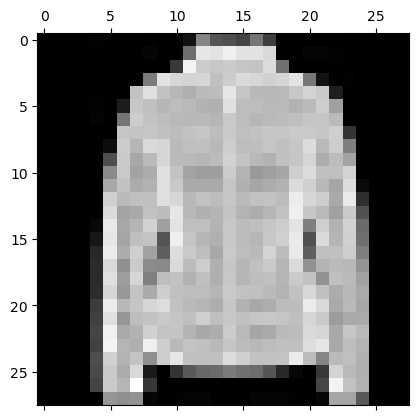

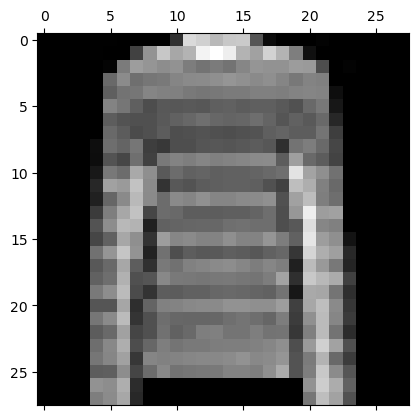

In [12]:
"""Grafico un abrigo y un pullover"""
prenda = dataframe.loc[dataframe['label'] == 0]

abrigo = dataframe.loc[25].drop('label').to_numpy()
matriz_abrigo = abrigo.reshape(28,28)
plt.matshow(matriz_abrigo,cmap='gray')

pullover = dataframe.loc[14].drop('label').to_numpy()
matriz_pullover =  pullover.reshape(28,28)
plt.matshow(matriz_pullover,cmap='gray')

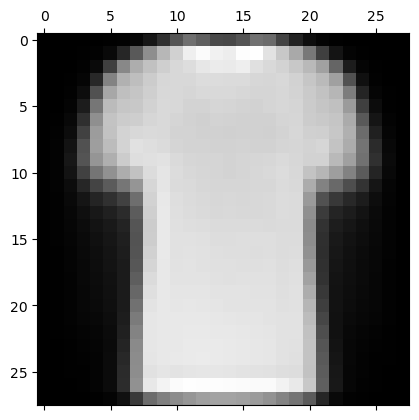

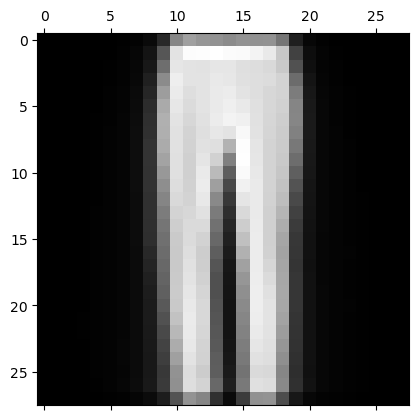

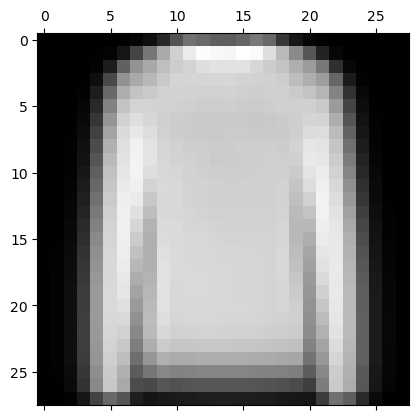

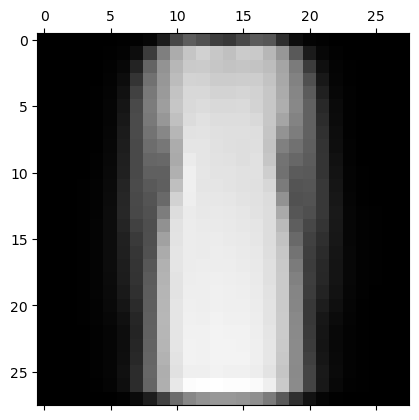

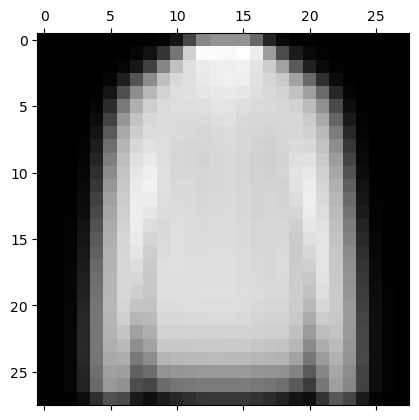

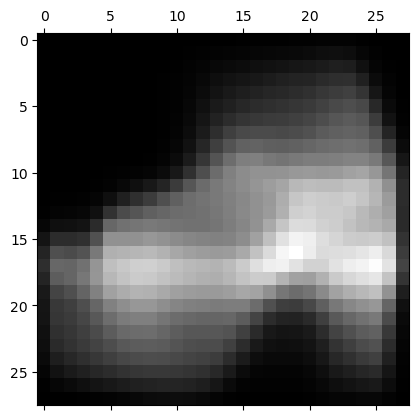

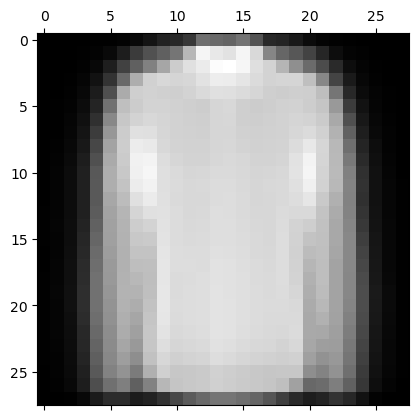

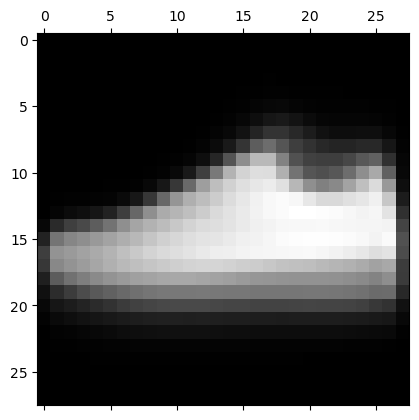

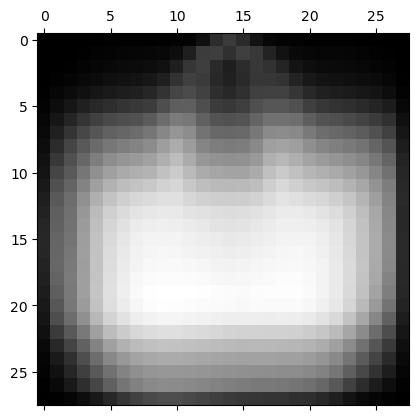

In [3]:
"""Ej 1: Graficos por prenda respecto al promedio de cada una"""
for i in range(9):
    prenda = dataframe.loc[dataframe['label'] == i]
    prenda = prenda.drop('label', axis =1)
    serie_prenda = prenda.mean()

    array_prenda = serie_prenda.to_numpy()
    matriz_prenda = array_prenda.reshape(28,28)
    plt.matshow(matriz_prenda,cmap='gray')

In [17]:
"""Ej 2: Separar el dataframe solo en remeras y pantalones y confeccionar un modelo predictivo"""
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


"""acoto el dataframe solo en remeras y pantalones"""
data_remeras = dataframe.loc[dataframe['label'] == 0]
data_pantalones = dataframe.loc[dataframe['label'] == 1]
df = pd.concat([data_remeras, data_pantalones],axis = 0).reset_index(drop=True) 


pixelRand1 = 'pixel' + str(randint(0, 784))
pixelRand2 = 'pixel' + str(randint(0, 784))
pixelRand3 = 'pixel' + str(randint(0, 784))

n_columnas_meditadas = ['pixel414','pixel174','pixel622']
n_columnas_random = [pixelRand1,pixelRand2,pixelRand3]
n_columnas_malas = ['pixel1','pixel2','pixel3']

X = df[n_columnas_malas]
y = df[['label']]
k = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=7)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['label']), y, test_size = 0.3, random_state=7)


neigh = KNeighborsClassifier(n_neighbors = k) 

# Entrenamos el modelo
neigh.fit(X_train, y_train) 

print(neigh.score(X_train, y_train))
print(neigh.score(X_test, y_test))




/home/alvaro/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.4963095238095238
0.5086111111111111


(0.0, 1.0)

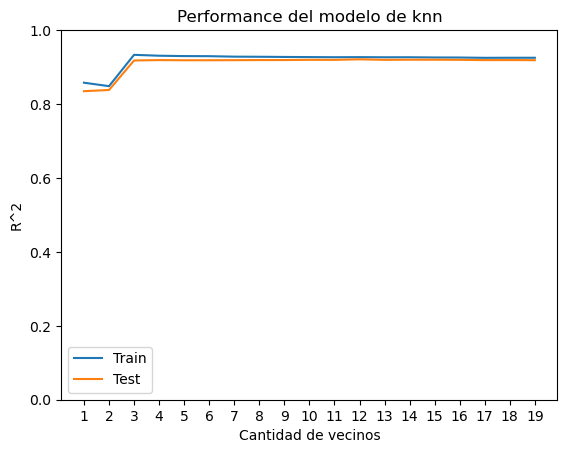

In [5]:
"""Realizamos varios experimentos para múltiples valores de k"""
import warnings
warnings.filterwarnings('ignore')

# Rango de valores por los que se va a mover k
valores_k = range(1, 20)
#  Cantidad de veces que vamos a repetir el experimento
Nrep = 5
# Matrices donde vamos a ir guardando los resultados
resultados_test  = np.zeros(( Nrep , len(valores_k)))
resultados_train = np.zeros(( Nrep , len(valores_k)))

# Realizamos la combinacion de todos los modelos (Nrep x k)
for i in range(Nrep):
    # Dividimos en test(30%) y train(70%)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3) 
    # Generamos el modelo y lo evaluamos
    for k in valores_k:
        # Declaramos el tipo de modelo
        neigh = KNeighborsClassifier(n_neighbors = k)
        # Entrenamos el modelo (con datos de train)
        neigh.fit(X_train, Y_train) 
        # Evaluamos el modelo con datos de train y luego de test
        resultados_train[i,k-1] = neigh.score(X_train, Y_train)
        resultados_test[i,k-1]  = neigh.score(X_test , Y_test )

# Promediamos los resultados de cada repeticion
promedios_train = np.mean(resultados_train, axis = 0) 
promedios_test  = np.mean(resultados_test , axis = 0) 

##################################################################
## Graficamos R2 en funcion de k (para train y test)
##################################################################
plt.plot(valores_k, promedios_train, label = 'Train')
plt.plot(valores_k, promedios_test, label = 'Test')
plt.legend()
plt.title('Performance del modelo de knn')
plt.xlabel('Cantidad de vecinos')
plt.ylabel('R^2')
plt.xticks(valores_k)
plt.ylim(0,1.00)

In [19]:
"""Gridsearch para obtener mejores hyper parametros para nuestro arbol"""
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz

#Armo mi set de test y train
X = dataframe.drop('label', axis =1)
y = dataframe[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=7)

#Creo mi arbol de decision
arbolito = DecisionTreeClassifier()

#Defino los hyper-parametros que voy a probar
hyper_params = {'max_depth' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'criterion' : ['gini','entropy']}

#Hago GridSearchCV para definir los mejores hyper-params para mi modelo
clf = GridSearchCV(arbolito, hyper_params, cv=5, verbose=1)

search = clf.fit(X_train,y_train)
print(search.best_params_)
print(search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'criterion': 'entropy', 'max_depth': 12}
0.8070238095238096


In [26]:
"""Obtención de exactitud utilizando el modelo obtenido anteriormente con el conjunto de Test"""
import graphviz

mejor_arbol = search.best_estimator_

test_score = mejor_arbol.score(X_test, y_test)

print(test_score)

"""Exportación del arbol generado"""
dot_data = export_graphviz(mejor_arbol, out_file=None, feature_names=None, class_names=None, label='all', filled=False, leaves_parallel=False, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=False, special_characters=False, precision=3, fontname='helvetica')

graph = graphviz.Source(dot_data)
graph.render("arbol", format = "png")

0.8116111111111111


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.107196 to fit


'arbol.png'